In [2]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
from itertools import cycle
from image_processing import ImageProcessing
import scienceplots
plt.style.use(['science', 'ieee', 'std-colors'])
plt.rcParams['font.size'] = 10
plt.rcParams.update({'figure.dpi': '100'})
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
# Define paths
DATASET_FOLDER = "/home/mariopasc/Python/Datasets/Meningiomas/Meningioma_Adquisition"
METADATA_PATH = os.path.join(DATASET_FOLDER, "metadata.xlsx")
PULSES = ['T1', 'T1SIN', 'SUSC', 'T2']
# Load metadata
metadata = pd.read_excel(io=METADATA_PATH, header=1)

In [4]:
# noise_modelling.py

from scipy.stats import gaussian_kde, rice
from scipy import ndimage
from skimage.filters import threshold_li, threshold_otsu
from skimage import exposure, morphology, measure
import numpy as np
from typing import Tuple, List

def segment_mri_image(image: np.ndarray, method: str = 'li', threshold: float = None, block_size: int = 35):
    """
    Segment an MRI image to separate the background from the cranial and intracranial regions.
    
    Args:
        image (np.ndarray): MRI image to segment.
        method (str, optional): Thresholding method. Options: 'otsu', 'weighted_mean','li'. Defaults to 'li'.
        threshold (float, optional): Threshold for separating background and intracranial region. Used only if method is 'manual'.
        block_size (int, optional): Block size for adaptive thresholding. Only used if method is 'adaptive'.
    
    Returns:
        np.ndarray: Mask where background is 0 and intracranial region is 1.
    """
    # Compute histogram of the image for 'weighted_mean'
    hist, hist_centers = exposure.histogram(image)
    
    # Select the thresholding method
    if method == 'otsu':
        threshold = threshold_otsu(image)
    
    elif method == 'weighted_mean':
        threshold = np.average(hist_centers, weights=hist)
    
    elif method == 'li':
        threshold = threshold_li(image)
    
    elif method == 'manual':
        if threshold is None:
            raise ValueError("For 'manual' method, a threshold value must be provided.")
    
    else:
        raise ValueError("Invalid method specified. Choose from 'otsu', 'weighted_mean', 'li'.")
    
    # Create mask where values less than or equal to the threshold are considered background
    background_mask = image <= threshold
    
    # Invert the mask so that 0 is background and 1 is intracranial region
    intracranial_mask = ~background_mask
    
    return intracranial_mask

def fill_mask(mask: np.ndarray, structure_size: int = 7, iterations: int = 3) -> np.ndarray:
    """
    Fills the mask by applying morphological closing and hole filling multiple times.
    
    Args:
        mask (np.ndarray): Binary mask to be processed.
        structure_size (int): Size of the structuring element for morphological operations.
        iterations (int): Number of times to apply the closing and hole-filling process.
    
    Returns:
        np.ndarray: Mask after applying the filter multiple times.
    """
    structuring_element = morphology.disk(structure_size)
    
    # Apply the filter multiple times
    for _ in range(iterations):
        # Morphological closing
        mask = morphology.closing(mask, structuring_element)
        # Hole filling
        mask = ndimage.binary_fill_holes(mask, structure=np.ones((structure_size, structure_size)))
    
    return mask.astype(np.uint8)

def find_largest_bbox(mask: np.ndarray, extra_margin: Tuple[int, int, int, int] = (0, 0, 0, 0)) -> Tuple[int, int, int, int]:
    """
    Finds the largest bounding box within a binary mask and optionally extends it by 
    specified margins in each direction. Adjusts the bounding box if it exceeds image 
    boundaries, showing a message when adjustments are made.

    Parameters:
    - mask (np.ndarray): A 2D binary array representing the mask where regions are defined by 1s.
    - extra_margin (tuple of int, optional): A tuple (min_row_margin, min_col_margin, 
      max_row_margin, max_col_margin) specifying the number of units to adjust the bounding 
      box in each direction. Default is (0, 0, 0, 0), meaning no extension.

    Returns:
    - largest_bbox (tuple): A tuple (min_row, min_col, max_row, max_col) defining the bounding 
      box coordinates for the largest region in the mask, with any specified margin applied and 
      adjusted to fit within the image boundaries.
    """
    # Label the connected components in the mask
    labeled_mask, _ = ndimage.label(mask == 1)
    regions = measure.regionprops(labeled_mask)
    
    # Initialize variables to find the largest bounding box
    largest_bbox = None
    max_area = 0
    
    # Iterate through each region to find the largest one by area
    for region in regions:
        min_row, min_col, max_row, max_col = region.bbox
        area = (max_row - min_row) * (max_col - min_col)
        
        # Update largest_bbox if the current region is larger
        if area > max_area:
            max_area = area
            largest_bbox = (min_row, min_col, max_row, max_col)
    
    # Apply the extra margin to the largest bounding box, if provided
    if largest_bbox is not None:
        min_row, min_col, max_row, max_col = largest_bbox
        min_row_margin, min_col_margin, max_row_margin, max_col_margin = extra_margin

        # Adjust the bounding box by the given margins
        min_row = max(0, min_row - min_row_margin)
        min_col = max(0, min_col - min_col_margin)
        max_row = min(mask.shape[0], max_row + max_row_margin)
        max_col = min(mask.shape[1], max_col + max_col_margin)
        
        # Final largest bbox after applying margins and adjustments
        largest_bbox = (min_row, min_col, max_row, max_col)

    return largest_bbox

def extract_noise_outside_bbox(image: np.ndarray, bbox: tuple[int, int, int, int], mask: np.ndarray) -> np.ndarray:
    """
    Extracts noise values from an image that lie outside a specified bounding box.

    Parameters:
    - image (np.ndarray): A 2D array representing the input image from which noise values are extracted.
    - bbox (tuple[int, int, int, int]): A tuple (min_row, min_col, max_row, max_col) defining the bounding box
      coordinates. These coordinates represent the region to exclude when extracting noise.
    - mask (np.ndarray): A binary or boolean mask array with the same shape as `image` where regions of interest 
      are defined. This mask is used to identify pixels outside the bounding box.

    Returns:
    - np.ndarray: An array of pixel values from `image` that are outside the specified bounding box.
    """
    min_row, min_col, max_row, max_col = bbox
    
    # Create a mask to exclude the bounding box region
    outside_bbox_mask = np.ones_like(mask, dtype=bool)
    outside_bbox_mask[min_row:max_row, min_col:max_col] = False
    
    # Extract noise values from the image that are outside the bounding box
    noise_values = image[outside_bbox_mask]
    return noise_values

def kde(noise_values: List[int], sigma: float = 1.0, num_points: int = 1000) -> np.ndarray:
    """
    Estimate the probability density function (PDF) of noise values using a Kernel Density Estimation (KDE) approach.

    This function computes a KDE of the provided noise values, allowing for adjustable smoothing with `sigma`
    and controlling the granularity of the output PDF with `num_points`.

    Parameters:
    - noise_values (List[int]): A list of noise values sampled from an MRI image's background or similar data.
    - sigma (float, optional): The bandwidth smoothing parameter for KDE. Controls the width of the Gaussian kernel.
      Higher values result in smoother KDEs. Default is 1.0.
    - num_points (int, optional): The number of points to evaluate the KDE over the range of `noise_values`.
      A higher number increases resolution of the PDF but may require more computation time. Default is 1000.

    Returns:
    - np.ndarray: The estimated PDF values across the specified number of points within the range of `noise_values`.
    """
    # Define the range over which to evaluate the KDE
    x_values = np.linspace(np.min(noise_values), np.max(noise_values), num_points)

    # Apply Gaussian KDE with specified bandwidth (sigma)
    kde = gaussian_kde(noise_values, bw_method=sigma)

    # Evaluate KDE over x_values and return
    return kde(x_values)

### Parzen Rosenblatt PDF per RM machine

Skipping patient 69 - file not found for pulse T1.
Skipping patient 18 - file not found for pulse T1.
Skipping patient 23 - file not found for pulse T1.
Skipping patient 27 - file not found for pulse T1.
Skipping patient 44 - file not found for pulse T1.


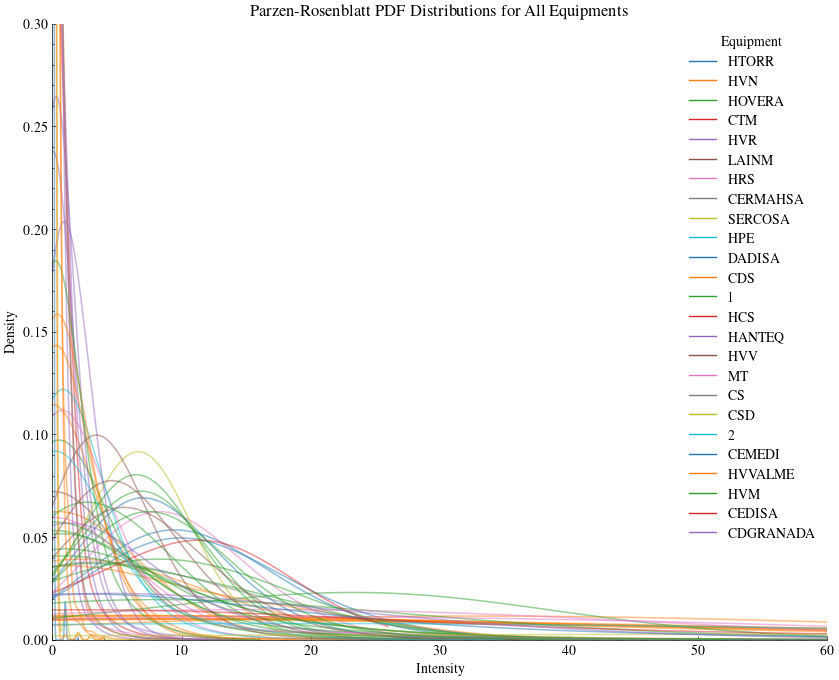

In [55]:
patient_machine = metadata.loc[:, (metadata.columns == "PACIENTE") | (metadata.columns == "EQUIPO")].dropna()

# Parameters
pulse = 'T1'
sigma = 1  # Sigma value for KDE

# Initialize image processing
processing = ImageProcessing()

def plot_kde_all_machines(patient_machine, pulse, sigma):
    """
    Plot the Parzen-Rosenblatt PDF for noise outside the bounding box for each machine.
    All machines are plotted on the same figure with unique colors. 
    The legend only includes machine names, while each patient’s PDF is colored based on their machine.
    """
    # Define color cycle for machines
    color_cycle = cycle(plt.cm.tab10.colors)  # Use matplotlib's tab10 color cycle for distinct colors

    plt.figure(figsize=(10, 8))
    
    # Iterate over each unique equipment
    for equipment in patient_machine['EQUIPO'].unique():
        color = next(color_cycle)
        kde_distributions = []
        
        # Find patients associated with this equipment
        patients = patient_machine[patient_machine['EQUIPO'] == equipment]['PACIENTE']
        
        for patient in patients:
            # Path to the MRI image for this patient and pulse
            rm_nrrd_path = f'/home/mariopasc/Python/Datasets/Meningiomas/Meningioma_Adquisition/RM/{pulse}/P{patient}/{pulse}_P{patient}.nrrd'
            
            # Check if the file exists, if not skip this patient
            if not os.path.exists(rm_nrrd_path):
                print(f"Skipping patient {patient} - file not found for pulse {pulse}.")
                continue
            
            # Process the image
            image = processing.open_nrrd_file(rm_nrrd_path)
            axis = processing.get_transversal_axis(rm_nrrd_path)
            original_im = processing.extract_middle_transversal_slice(image, transversal_axis=axis)
            
            # Segment and find the noise outside bounding box
            mask = segment_mri_image(original_im)
            mask = fill_mask(mask, structure_size=7, iterations=3)
            largest_bbox_margin = find_largest_bbox(mask, extra_margin=(5, 5, 5, 5))
            noise_outside_bbox = extract_noise_outside_bbox(image=original_im, bbox=largest_bbox_margin, mask=mask)
            
            # Calculate KDE PDF for noise values
            kde_pdf = kde(noise_outside_bbox, sigma=sigma)
            kde_distributions.append((kde_pdf, noise_outside_bbox))
        
        ax = plt.subplot(111)
        # Plot KDEs for each patient in this machine with the same color
        for kde_pdf, noise_values in kde_distributions:
            x = np.linspace(np.min(noise_values), np.max(noise_values), 1000)
            plt.plot(x, kde_pdf, color=color, alpha=0.5, linewidth=1.1)  # Lower alpha to overlay multiple KDEs smoothly
        
        # Add legend entry for this equipment
        plt.plot([], [], color=color, label=equipment)  # Dummy plot for legend

    # Final plot adjustments
    plt.title(f'Parzen-Rosenblatt PDF Distributions for All Equipments')
    plt.xlabel('Intensity')
    # Set axis limits
    plt.xlim(0, 60)
    plt.ylim(0, 0.3)
    ax.spines[['right', 'top']].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    plt.tick_params(top=False, right=False)  
    plt.ylabel('Density')
    plt.legend(title="Equipment", loc="upper right")
    plt.savefig("../docs/figures/Parzen_Rosenblatt_PDF_for_All_Equipments.pdf")
    plt.show()

# Run the function
plot_kde_all_machines(patient_machine, pulse, sigma)


### Parzen Rosenblatt per RM Pulse

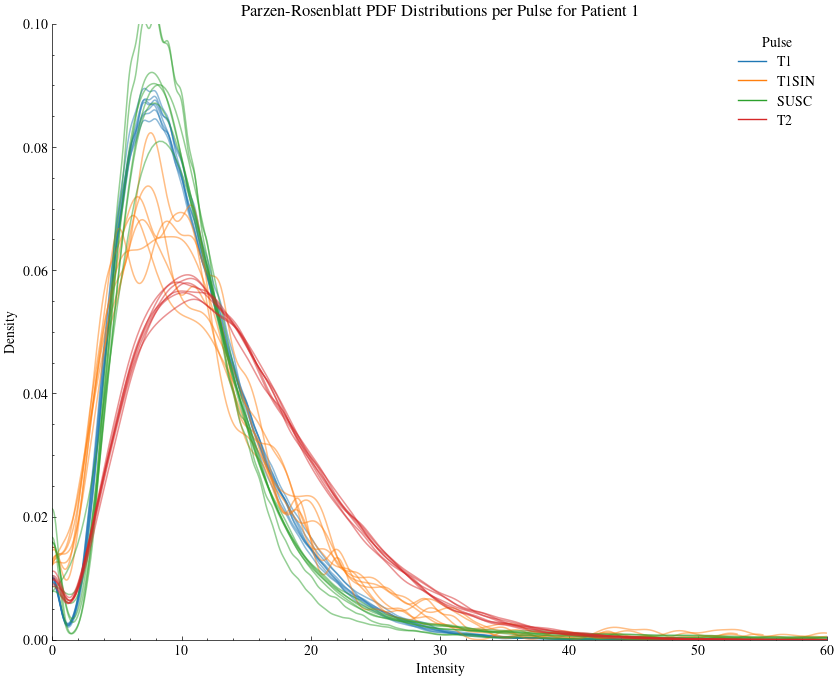

In [12]:

# Load metadata
metadata = pd.read_excel(io=METADATA_PATH, header=1)
patient_machine = metadata.loc[:, (metadata.columns == "PACIENTE") | (metadata.columns == "EQUIPO")].dropna()

# Parameters
sigma = .1  # Sigma value for KDE
NUMBER_SLICES = 3  # Define the number of slices to take around the middle

# Initialize image processing
processing = ImageProcessing()

def find_valid_patient_with_pulses(metadata, pulses):
    """
    Find a patient with valid NRRD files for all required pulses.
    """
    for patient in metadata['PACIENTE'].unique():
        valid = True
        for pulse in pulses:
            rm_nrrd_path = f"{DATASET_FOLDER}/RM/{pulse}/P{patient}/{pulse}_P{patient}.nrrd"
            if not os.path.exists(rm_nrrd_path):
                valid = False
                break
        if valid:
            return patient
    return None

def plot_kde_per_pulse(patient, pulses, num_slices, sigma):
    """
    Plot Parzen-Rosenblatt PDF for a specified patient and given pulses.
    """
    plt.figure(figsize=(10, 8))
    colors = cycle(plt.cm.tab10.colors)  # Color for each pulse
    ax = plt.subplot(111)
    for pulse in pulses:
        color = next(colors)
        
        # Load and process images for each slice around the middle
        rm_nrrd_path = f"{DATASET_FOLDER}/RM/{pulse}/P{patient}/{pulse}_P{patient}.nrrd"
        image = processing.open_nrrd_file(rm_nrrd_path)
        axis = processing.get_transversal_axis(rm_nrrd_path)
        middle_slice_index = image.shape[axis] // 2
        kde_distributions = []
        
        for i in range(-num_slices, num_slices + 1):
            slice_index = middle_slice_index + i
            sliced_image = np.take(image, slice_index, axis=axis)

            # Segment and extract noise from outside the bounding box
            mask = segment_mri_image(sliced_image)
            mask = fill_mask(mask, structure_size=7, iterations=3)
            largest_bbox_margin = find_largest_bbox(mask, extra_margin=(5, 5, 5, 5))
            noise_outside_bbox = extract_noise_outside_bbox(image=sliced_image, bbox=largest_bbox_margin, mask=mask)
            
            # Calculate KDE PDF for noise values
            kde_pdf = kde(noise_outside_bbox, sigma=sigma)
            kde_distributions.append((kde_pdf, noise_outside_bbox))
        
        # Plot KDE distributions for this pulse
        for kde_pdf, noise_values in kde_distributions:
            x = np.linspace(np.min(noise_values), np.max(noise_values), 1000)
            plt.plot(x, kde_pdf, color=color, alpha=0.5, linewidth=1.1)
        
        # Add legend entry for the pulse
        plt.plot([], [], color=color, label=pulse)

    # Final plot adjustments
    plt.title(f'Parzen-Rosenblatt PDF Distributions per Pulse for Patient {patient}')
    plt.xlabel('Intensity')
    plt.ylabel('Density')
    plt.xlim(0, 60)  # Adjust if necessary
    plt.ylim(0, 0.1)
    ax.spines[['right', 'top']].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    plt.legend(title="Pulse", loc="upper right")
    plt.show()

# Find a valid patient with all pulses
patient = find_valid_patient_with_pulses(metadata, PULSES)
if patient:
    plot_kde_per_pulse(patient, PULSES, NUMBER_SLICES, sigma)
else:
    print("No patient found with all required pulses.")

### Parzen Rosenblatt PDF per $\sigma$ and pulse

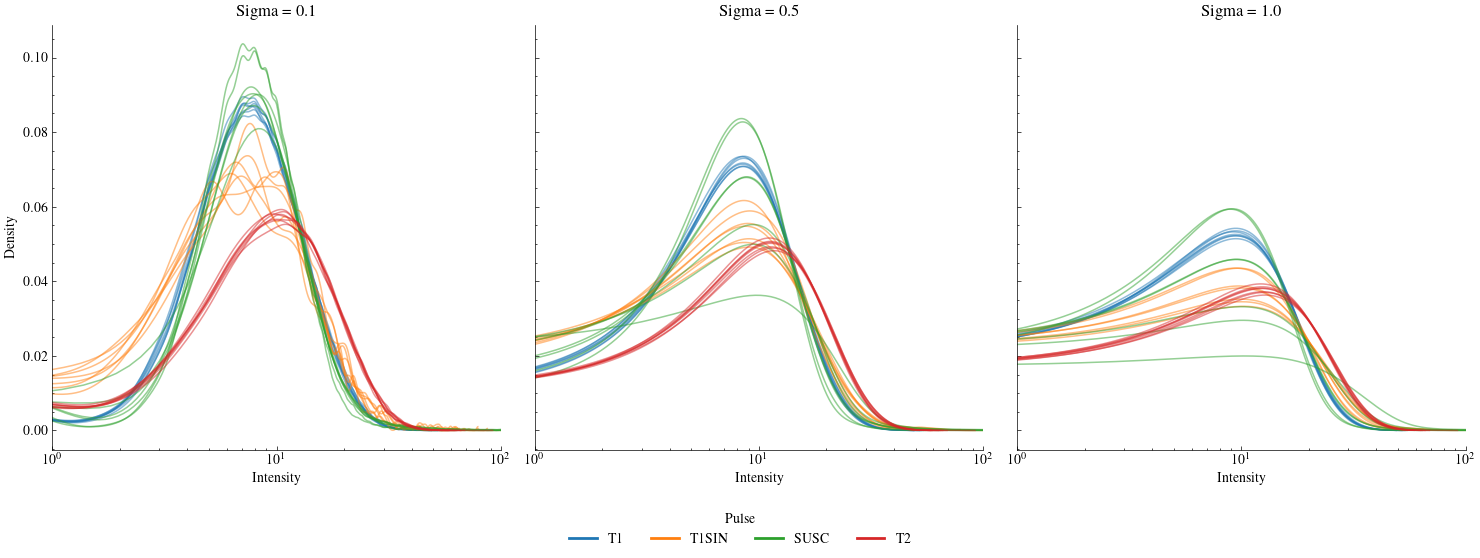

In [15]:
# User-defined parameters
NUMBER_SLICES = 3  # Define the number of slices to take around the middle
SIGMA_VALUES = [0.1, 0.5, 1.0]  # List of sigma values for KDE

# Initialize image processing
processing = ImageProcessing()

def find_valid_patient_with_pulses(metadata, pulses):
    """
    Find a patient with valid NRRD files for all required pulses.
    """
    for patient in metadata['PACIENTE'].unique():
        valid = True
        for pulse in pulses:
            rm_nrrd_path = f"{DATASET_FOLDER}/RM/{pulse}/P{patient}/{pulse}_P{patient}.nrrd"
            if not os.path.exists(rm_nrrd_path):
                valid = False
                break
        if valid:
            return patient
    return None

def plot_kde_per_pulse_multiple_sigma(patient, pulses, num_slices, sigma_values):
    """
    Plot Parzen-Rosenblatt PDF for a specified patient and given pulses
    with multiple sigma values, arranged in a single row of subplots.
    """
    fig, axes = plt.subplots(1, len(sigma_values), figsize=(15, 6), sharey=True)
    colors = cycle(plt.cm.tab10.colors)  # Color cycle for pulses
    
    for ax, sigma in zip(axes, sigma_values):
        color_cycle = cycle(plt.cm.tab10.colors)  # Reset color cycle for each sigma value
        
        for pulse in pulses:
            color = next(color_cycle)
            
            # Load and process images for each slice around the middle
            rm_nrrd_path = f"{DATASET_FOLDER}/RM/{pulse}/P{patient}/{pulse}_P{patient}.nrrd"
            image = processing.open_nrrd_file(rm_nrrd_path)
            axis = processing.get_transversal_axis(rm_nrrd_path)
            middle_slice_index = image.shape[axis] // 2
            kde_distributions = []
            
            for i in range(-num_slices, num_slices + 1):
                slice_index = middle_slice_index + i
                sliced_image = np.take(image, slice_index, axis=axis)

                # Segment and extract noise from outside the bounding box
                mask = segment_mri_image(sliced_image)
                mask = fill_mask(mask, structure_size=7, iterations=3)
                largest_bbox_margin = find_largest_bbox(mask, extra_margin=(5, 5, 5, 5))
                noise_outside_bbox = extract_noise_outside_bbox(image=sliced_image, bbox=largest_bbox_margin, mask=mask)
                
                # Calculate KDE PDF for noise values
                kde_pdf = kde(noise_outside_bbox, sigma=sigma)
                kde_distributions.append((kde_pdf, noise_outside_bbox))
            
            # Plot KDE distributions for this pulse
            for kde_pdf, noise_values in kde_distributions:
                x = np.linspace(np.min(noise_values), np.max(noise_values), 1000)
                ax.plot(x, kde_pdf, color=color, alpha=0.5, linewidth=1.1)
        
        # Title and axis settings for each subplot
        ax.set_title(f'Sigma = {sigma}')
        ax.set_xlabel('Intensity')
        ax.set_xlim(1, 100)  # Adjust if necessary
        ax.set_xscale('log')  # Optional, depending on data distribution
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.get_xaxis().tick_bottom()
        ax.get_yaxis().tick_left()
        
    # Y-axis label only on the leftmost plot
    axes[0].set_ylabel('Density')

    # Add a single legend below all plots
    handles = [plt.Line2D([0], [0], color=next(colors), lw=2) for _ in pulses]
    labels = pulses
    fig.legend(handles, labels, title="Pulse", loc="lower center", ncol=len(pulses))
    
    # Adjust layout and show plot
    plt.tight_layout(rect=[0, 0.1, 1, 0.95])  # Leave space at the bottom for the legend
    plt.savefig("../docs/figures/PR_PDF_per_sigma_pulse_same_patient.pdf")
    plt.show()

# Find a valid patient with all pulses
patient = find_valid_patient_with_pulses(metadata, PULSES)
if patient:
    plot_kde_per_pulse_multiple_sigma(patient, PULSES, NUMBER_SLICES, SIGMA_VALUES)
else:
    print("No patient found with all required pulses.")